In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages and Load Data

In [ ]:
!pip install transformers==4.28.0
!pip install tensorflow==2.11.0

In [ ]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5, style = 'whitegrid', color_codes=True)
import torch

import ast
from datetime import datetime
from tqdm import tqdm
import time

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_rows', 100)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df_s = pd.read_csv('/content/drive/MyDrive/Skripsi/Twitter_VADER.csv')
#Remove columns not needed.
df_s = df.drop(columns=['Dominant_Topic', 'Topic_Name', 'VADER_Polarity'])

In [ ]:
df_s.head()

,Text,Token,Dominant_Topic,Contribution%,Topic_Name
0,mathlievetradingsignaltime075924design closing point accord thecryptocurrency ai btc etherum bnb orc20 bch xrp usdt shib link dydx chatgpt,"[design, closing, point, accord, ai, btc, etherum, bnb, orc, bch, xrp, usdt, shib, link, dydx, chatgpt]",3,60.46,T3 Experiment AI
1,chatgpt cause website scrap stop get updated plan train model still also think far early ai company get sue oblivion ip theft,"[chatgpt, cause, website, scrap, stop, get, updated, plan, train, model, still, also, think, far, early, ai, company, get, sue, oblivion, ip, theft]",1,91.16,T1 Information Technology
2,one way education foundation could stop pay many people endless englishmajoring chatgpt start pay people system work systemsmatter,"[one, way, education, foundation, could, stop, pay, many, people, endless, englishmajoring, chatgpt, start, pay, people, system, work, systemsmatter]",4,91.76,T4 Random Ask and Conversations
3,african union commission fall victim cybercrime use deep fake impersonate head moussa faki incident highlight need strong cybersecurity measure worldwide cybersecurity deepfakes africanunioncommis...,"[african, union, commission, fall, victim, cybercrime, use, deep, fake, impersonate, head, moussa, faki, incident, highlight, need, strong, cybersecurity, measure, worldwide, cybersecurity, deepfa...",1,74.41,T1 Information Technology
4,chatgpt,[chatgpt],1,25.00,T1 Information Technology


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel
import os
from collections import Counter
import regex as re
import statistics
import math

In [ ]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
#task='sentiment'
#MODEL_NAME = f"cardiffnlp/twitter-roberta-base-{task}"
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [ ]:
#load the model and tokenizer

#model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
#tokenizer = AutoTokenizer.from_pretrained(model_path)
#roberta_model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
X_data = df_s[['Text']].to_numpy().reshape(-1)
y_data = df_s[['VADER_Sentiment']].to_numpy().reshape(-1)

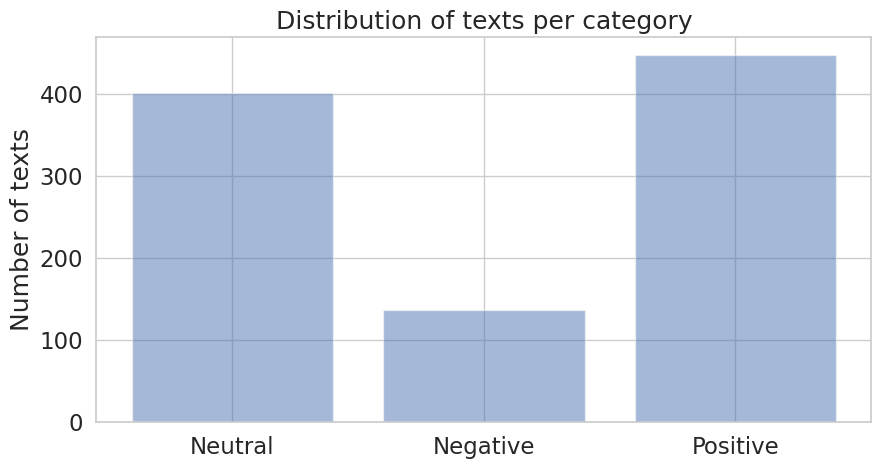

Counter({'Positive': 447, 'Neutral': 401, 'Negative': 136})


In [ ]:
categories = df_s[['VADER_Sentiment']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
def calculate_stats(df_s, split_char=' '):
    categories = df_s['VADER_Sentiment'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df_s.iterrows():
        text = row['Text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['VADER_Sentiment']

        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=4):
    categories = df_s['VADER_Sentiment'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [ ]:
df_stats = calculate_stats(df_s)
df_stats['per_category']

,lengths,mean,stdev
Neutral,"[17, 23, 1, 18, 9, 2, 12, 13, 7, 2, 5, 6, 5, 23, 6, 5, 5, 3, 2, 13, 14, 2, 2, 25, 13, 9, 18, 4, 10, 25, 9, 7, 4, 5, 11, 7, 5, 10, 26, 3, 5, 20, 7, 15, 9, 2, 13, 6, 6, 5, 20, 22, 27, 9, 4, 10, 8, 8...",10.643392,7.403378
Negative,"[22, 18, 4, 15, 9, 8, 6, 6, 9, 27, 3, 11, 5, 12, 17, 4, 13, 14, 12, 28, 24, 6, 9, 19, 10, 28, 20, 27, 12, 30, 14, 6, 15, 6, 5, 9, 24, 24, 17, 19, 18, 12, 6, 6, 6, 4, 9, 25, 11, 27, 6, 20, 14, 13, ...",14.720588,7.565703
Positive,"[41, 2, 13, 19, 37, 6, 20, 31, 15, 26, 18, 16, 15, 3, 4, 2, 6, 27, 29, 19, 23, 14, 6, 17, 18, 8, 20, 17, 18, 13, 21, 1, 24, 26, 5, 10, 14, 24, 27, 11, 25, 7, 2, 6, 18, 14, 23, 3, 32, 16, 9, 23, 13...",16.729306,8.845744


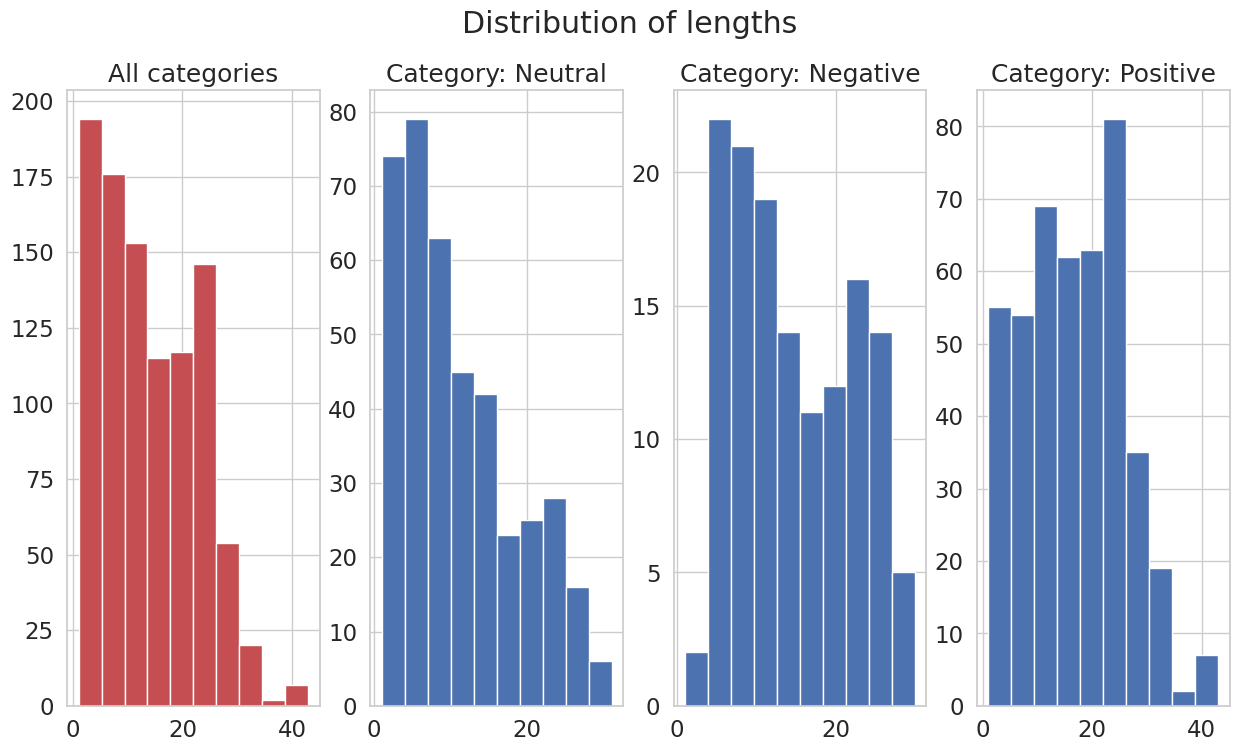

In [ ]:
display_lengths_histograms(df_stats)

In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df_s['VADER_Sentiment'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 984
Number of categories: 3
Done!


In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c

    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'Neutral', 1: 'Negative', 2: 'Positive'}

In [ ]:
# Split into train and test datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [ ]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 256)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                            

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/3


86/86 [==============================] - 84s 548ms/step - loss: 15.7824 - accuracy: 0.4142 - val_loss: 1.0922 - val_accuracy: 0.4426
Epoch 2/3
86/86 [==============================] - 42s 485ms/step - loss: 1.0830 - accuracy: 0.4593 - val_loss: 1.0780 - val_accuracy: 0.4426
Epoch 3/3
86/86 [==============================] - 42s 486ms/step - loss: 1.0675 - accuracy: 0.4593 - val_loss: 1.0656 - val_accuracy: 0.4426


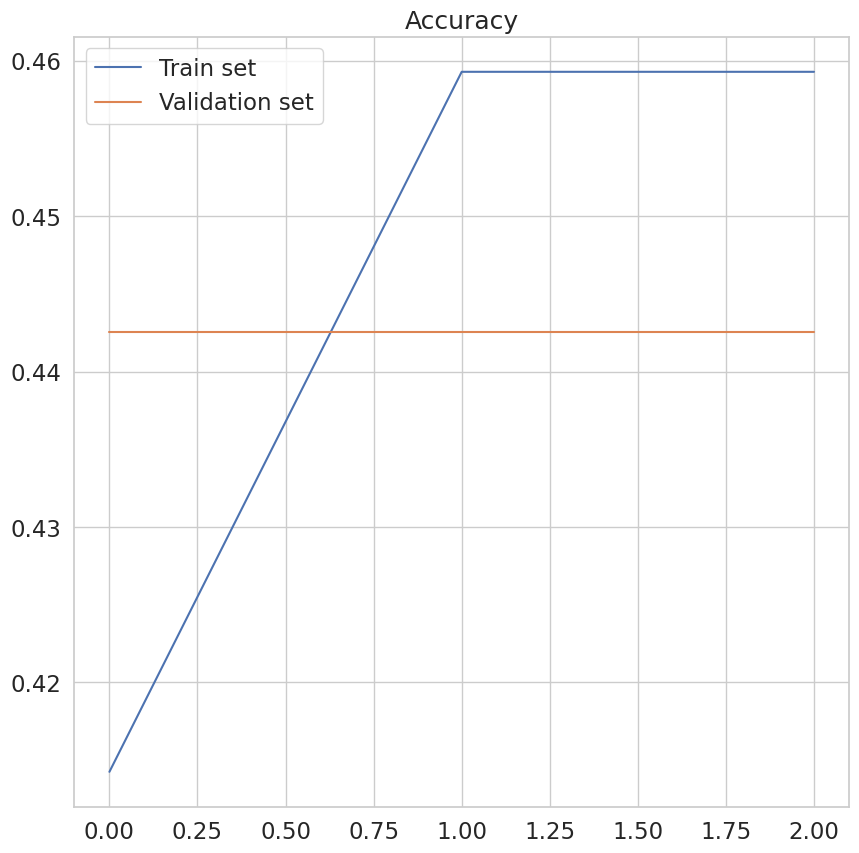

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 44.26%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = [np.argmax(i) for i in model.predict(X_test)]
# Membangun confusion matrix
cm = confusion_matrix(y_test, predictions)

# Membuat classification report
report = classification_report(y_test, predictions)
"{0: 'Neutral', 1: 'Negative', 2: 'Positive'}"
# Menampilkan confusion matrix dan classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

10/10 [==============================] - 8s 478ms/step
Confusion Matrix:
[[  0   0 119]
 [  0   0  46]
 [  0   0 131]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00        46
           2       0.44      1.00      0.61       131

    accuracy                           0.44       296
   macro avg       0.15      0.33      0.20       296
weighted avg       0.20      0.44      0.27       296



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 5s 479ms/step


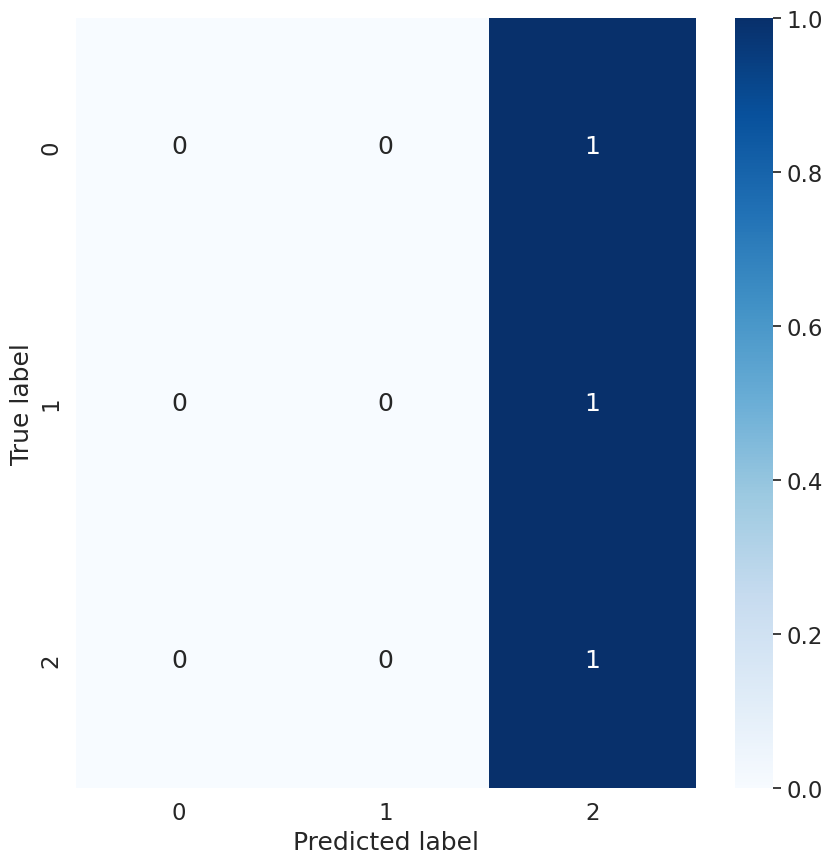

In [ ]:
plot_confusion_matrix(X_test, y_test, model)